# Example usage of the UPI package

In this notebook, we show the use of the `unstable_populations` package and calculate UPI, PSI and $\chi^2$ for example distributions. More information about the measures can be found in Haas & Sibbald, of which the figures are generated here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  # Many divides by 0 and log(0) in this notebook...

from unstable_populations import upi, psi, KL

### Example: shifting Gaussians

In this example, we will create two populations by randomly drawing from Gaussian distributions. We will measure the shift by means of weighted UPI, unweughted UPI, PSI and $\chi^2$. In the first example we will take two equally large populations of 1000 elements, after which we will also calculate the same for smaller populations as well as unequally sized populations.  We will do the experiment with the deafult `numpy` binning scheme as well as with a fixed numer of bins. Note that both populations will be binned to the *same bins*.

We will use Gaussians of given center and a standard deviation ($\sigma$) of 1, and report the shift in terms of $d/\sigma$, where $d$ is the difference between the centers. We will sample 100 times and report statistics about the measures of difference.

In [2]:
shifts = pd.DataFrame()

np.random.seed(42)

samplesize = 100
pop1size = 1000
pop2sizes = [50, 100, 1000]

bins='auto'
# bins = np.array([-np.inf, -1, 0, 1, np.inf])
# bins=5

for pop2size in pop2sizes:
    for d in [0, .5, 1, 1.5, 2, 2.5]:

        upis = []
        psis = []
        kls = []

        for sample in range(samplesize):
            pop1 = np.random.normal(loc=0, scale=1, size=pop1size)
            pop2 = np.random.normal(loc=d, scale=1, size=pop2size)

            upis.append(upi(pop1, pop2, bin_data=True, bins=bins))
            psis.append(psi(pop1, pop2, bin_data=True, bins=bins))
            kls.append(KL(pop1, pop2, bin_data=True, bins=bins) + KL(pop2, pop1, bin_data=True, bins=bins))

        upis = np.array(upis)
        psis = np.array(psis)
        kls = np.array(kls)

        shifts = pd.concat([shifts, pd.DataFrame({'UPI':upis,   
                                                  'PSI':psis, 
                                                  'KL (measured)':kls,
                                                  'KL (theory)': np.ones(samplesize)*float(d)**2,
                                                  'shift':np.ones(samplesize)*d, 
                                                  'Size pop 1':np.ones(samplesize)*pop1size, 
                                                  'Size pop 2':(np.ones(samplesize)*pop2size).astype(int)})])

shifts = pd.melt(shifts, id_vars=['shift', 'Size pop 1', 'Size pop 2'], var_name='Measure')

In [42]:
# The number of samples (so also the percentage) with a PSI that is *defined*
with pd.option_context('mode.use_inf_as_null', True):
    shift_finite = shifts.dropna()
perc_PSI_NAN = shift_finite[shift_finite.Measure == 'PSI'].groupby(['shift', 'Size pop 2']).value.count()
perc_PSI_NAN.reset_index()

,shift,Size pop 2,value
0,0.0,1000,3
1,0.5,1000,1


In [4]:
shifts[shifts.Measure == 'KL (theory)'].head()

,shift,Size pop 1,Size pop 2,Measure,value
5400,0.0,1000.0,50,KL (theory),0.0
5401,0.0,1000.0,50,KL (theory),0.0
5402,0.0,1000.0,50,KL (theory),0.0
5403,0.0,1000.0,50,KL (theory),0.0
5404,0.0,1000.0,50,KL (theory),0.0


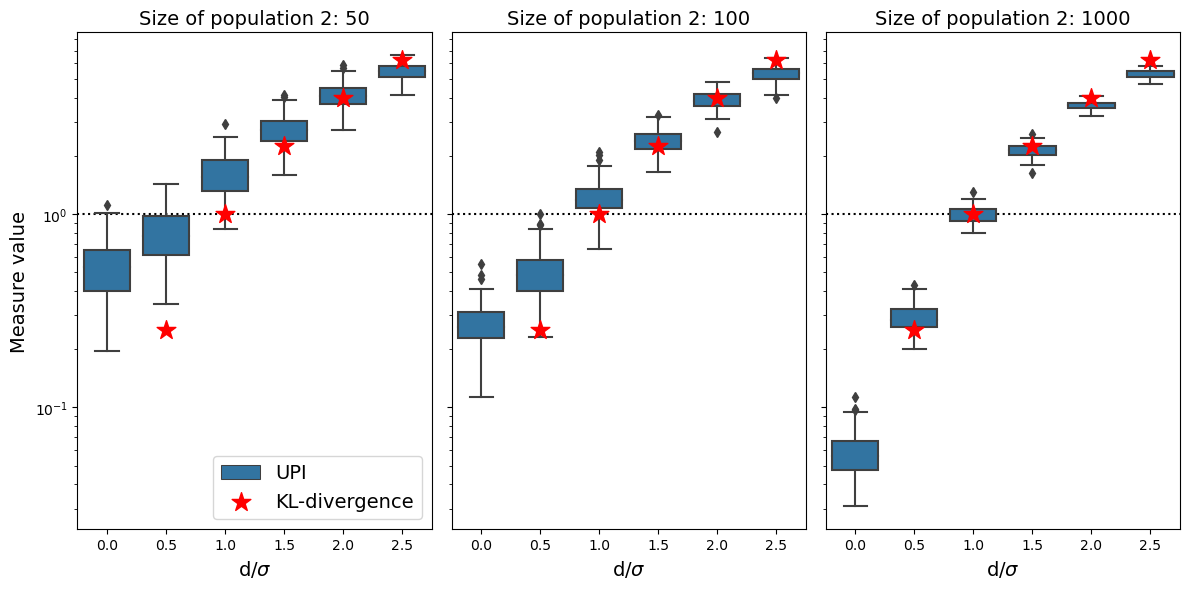

In [48]:
dsizes = np.unique(shifts['Size pop 2'])
nd = len(dsizes)

fsize=14

fig, ax = plt.subplots(nrows=1, ncols=nd, figsize=(12,6), sharey=True, sharex=True)

for isize, sizep2 in enumerate(dsizes):
    data = shifts[(
        (shifts['Size pop 2'] == sizep2) &
        ~(shifts.Measure.str.startswith('KL')) &
        (shifts.Measure != "PSI")
        )]
    sns.boxplot(data=data, x='shift', y='value', hue='Measure', ax=ax[isize], zorder=0)
    ax[isize].legend_.remove()
    ax[isize].set_title(f'Size of population 2: {sizep2}', fontsize=fsize)
    ax[isize].set_xlabel('d/$\sigma$', fontsize=fsize)
    ax[isize].semilogy()
    xl = ax[isize].get_xlim()
    ax[isize].hlines(y=1, xmin=xl[0], xmax=xl[1], linestyle='dotted', color='k', zorder=-1)
    ax[isize].scatter(np.arange(0,6, 1),np.arange(0,3, 0.5)**2, marker="*", color='red', label='KL-divergence', s=200, zorder=1)
    if isize == 0: 
        ax[isize].legend(fontsize=fsize, loc='lower right')
        ax[isize].set_ylabel('Measure value', fontsize=fsize)
    else:
        ax[isize].set_ylabel(None)
    fig.tight_layout()
# fig.savefig('figures/shifting_gaussians.pdf')

In [15]:
np.arange(0,3, 0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

In [55]:
legend

{'UPI': <matplotlib.patches.Rectangle at 0x7fa39e9281c0>}

PSIs are very comparable to unweighted UPI as long as they ar not NaN. (try with commented out few hand-set bins).

### Some artifical few-category sets

In ML projects it is not uncommon to have categorical variables with only very few possible labels. In this example we will make data sets with such properties and calculate the shift measures for these.

In [8]:
def print_all(pop1, pop2):
    
    print(f'Population 1: {pop1}')
    print(f'Population 2: {pop2}')

    print(f'UPI: {upi(pop1, pop2)}')
    print(f'PSI: {psi(pop1, pop2)}')

    print('\n--------\n')



pop1 = {'A':10, 'B':10, 'C':10}
pop2 = {'A':10, 'B':10, 'C':10}
pop2wiggle = {'A':10, 'B':9, 'C':11}
pop2huge = {'A':100, 'B':100, 'C':100}
pop2hw = {'A':100, 'B':90, 'C':110}
pop3 = {'A':15, 'B':15, 'C':0}
pop4 = {'A':10, 'B':10, 'C':0}
pop5 = {'A':10, 'B':10, 'C':1}
pop6 = {'A':9, 'B':11, 'C':1}
pop7 = {'A':10, 'B':10, 'C':5}

pop8 = {'A':1000, 'B':1000, 'C':5, 'D':20}
pop9 = {'A':100, 'B':100, 'C':15, 'D':10}
pop10 = {'A':1000, 'B':1000, 'C':15, 'D':10, 'E':5, 'F':5, 'G':15, 'H':1, 'I':2}
pop11 = {'A':950, 'B':1050, 'C':2, 'D':1, 'E':10, 'F':5, 'G':2, 'H':10, 'I':20}
pop12 = {'A':2, 'B':1050, 'C':950, 'D':1, 'E':10, 'F':5, 'G':2, 'H':10, 'I':20}

print_all(pop1, pop2)
print_all(pop1, pop2wiggle)
print_all(pop1, pop2huge)
print_all(pop1, pop2hw)
print_all(pop1, pop3)
print_all(pop1, pop4)
print_all(pop1, pop5)
print_all(pop1, pop6)
print_all(pop1, pop7)
print_all(pop3, pop4)
print_all(pop4, pop5)
print_all(pop4, pop6)
print_all(pop4, pop7)
print_all(pop5, pop6)
print_all(pop8, pop9)
print_all(pop8, pop10)
print_all(pop9, pop10)
print_all(pop10, pop11)
print_all(pop10, pop12)
print_all(pop11, pop12)

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 10, 'B': 10, 'C': 10}
UPI: 0.0
PSI: 0.0

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 10, 'B': 9, 'C': 11}
UPI: 0.006368507892090301
PSI: 0.006689023182071707

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 100, 'B': 100, 'C': 100}
UPI: 0.0
PSI: 0.0

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 100, 'B': 90, 'C': 110}
UPI: 0.006628361958172168
PSI: 0.006689023182071707

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 15, 'B': 15, 'C': 0}
UPI: 1.144662401495049
PSI: inf

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 10, 'B': 10, 'C': 0}
UPI: 1.086032179340494
PSI: inf

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 10, 'B': 10, 'C': 1}
UPI: 0.5708845434931096
PSI: 0.6578814551411559

--------

Population 1: {'A': 10, 'B': 10, 'C': 10}
Population 2: {'A': 9, 'B': 11, 'C': 1}
